In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from IPython.display import display, HTML

import warnings
# warnings.filterwarnings('ignore')

# load custom functions
os.chdir('C:/Users/kyleg/Entity-Matching-in-Online-Retail')
#  os.chdir('H:/kgilde/Entity-Matching-in-Online-Retail')
exec(open("utility_functions.py").read())

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# source: https://stackoverflow.com/a/28073228/4463701

# Entity Matching for Online Marketplaces



In [18]:
# Load Data
# DATA_DIRECTORY = '//files/share/goods/OI Team'
DATA_DIRECTORY = 'D:/Documents/Large-Scale Product Matching/'
os.chdir(DATA_DIRECTORY)

train_test_feature_pairs = pd.read_csv('train_test_feature_pairs.csv')
train_test_offer_features = pd.read_csv('train_test_offer_features.csv')
train_test_normalized_features = pd.read_csv('train_test_normalized_features.csv')

var_importance = pd.read_csv('logreg-variable-importance.csv').set_index('Variable')
var_coefficients = pd.read_csv('logreg-variable-coefficients.csv').set_index('Variable')

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## What is Entity Matching (EM)?

## Why is EM needed for online marketplaces?

In [19]:
test_matches = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                      (train_test_feature_pairs.dataset == 'test')][['file_category', 
                                                                                   'name_1', 
                                                                                   'name_2']]\
.sample(4, random_state=1)

pd.set_option('display.max_colwidth', 0)
h = HTML(test_matches.to_html(index=False))
display(h)

# my_file = open('plots/table_1_matched_offer_pairs.html', 'w')
# my_file.write(h.data)
# my_file.close()

file_category,name_1,name_2
shoes,nike sportswear air force 1 07 white,sneakers buty nike air force 1 07 low white 315122 111
computers,323146 b21 bl20p g2 1p xeon 3 06ghz,323146 b21 bl20p xeon 3 06ghz
watches,daniel wellington dapper sheffield rose gold,daniel wellington men s dapper 38mm sheffield rose watch
cameras,canon eos rebel t5i,canon eos rebel t5i 18 135mm is stm digital slr camera kit black


In [20]:
test_ids = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                    (train_test_feature_pairs.dataset == 'test')]\
                [['offer_id_1', 'offer_id_2']]\
                .stack()\
                .unique()
                

len(test_ids)

895

## Exploratory Data Analysis

### Dataset Origin



Text(0.5,1,'Top Domains')

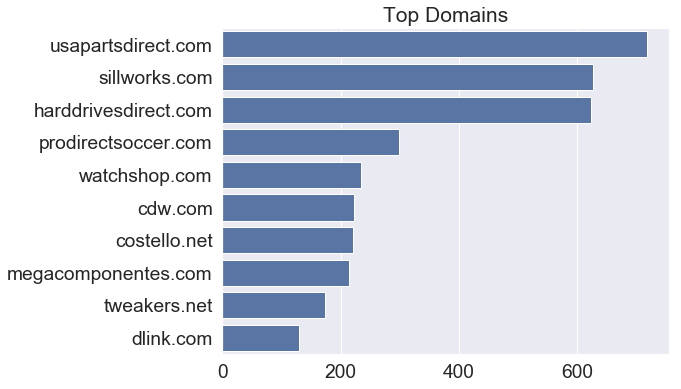

In [21]:
domains = train_test_offer_features.domain.str.replace('www\.|de\.', '')\
    .value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.75)

sns.barplot(x=domains.values, y=domains.index, 
            color="b")\
            .set_title('Top Domains')

### Offer Features

#### There are 10 offer features that comprise 4 broad feature types.

- 6 are short-to-medium free-text attributes
    - 4 of them are types of indentifiers: gtin, mpm, sku and a generic identifier
    - 2 of them are the brand and manufacturer

- The offer name is the medium-length text attributes
    
- The description is a longer free-text attribute

- The price is a numeric feature

In [22]:
SHORT_TEXT_FEATURES = ['gtin', 'mpn', 'sku', 'identifier', 'brand', 'manufacturer']
MEDIUM_LONG_TEXT_FEATURES = ['name', 'description']
OTHER_FEATURES = ['price']
ALL_FEATURES = SHORT_TEXT_FEATURES + MEDIUM_LONG_TEXT_FEATURES + OTHER_FEATURES
                  
train_test_offer_features_only = train_test_offer_features[ALL_FEATURES]
test_offer_features_only = train_test_offer_features.loc[train_test_offer_features.offer_id.isin(test_ids), ALL_FEATURES]

display(HTML(train_test_offer_features_only.head(3).to_html(index=False)))


gtin,mpn,sku,identifier,brand,manufacturer,name,description,price
NaN,672631b21,NaN,NaN,hp enterprise,NaN,672631 b21 hp 16gb 1x16gb sdram dimm,hp 16gb 1x16gb dual rank x4 pc3 12800r ddr3 1600 registered cas 11 memory kitpart number s option part 672631 b21 hp smartbuy part 672631 s21 spare part 684031 001 assembly part 672612 081,155.94
NaN,672631b21,NaN,NaN,hp enterprise,NaN,672631 b21 hp 16gb 1x16gb sdram dimm,hp 16gb 1x16gb dual rank x4 pc3 12800r ddr3 1600 registered cas 11 memory kitpart number s option part 672631 b21 hp smartbuy part 672631 s21 spare part 684031 001 assembly part 672612 081,155.94
NaN,NaN,NaN,NaN,NaN,hp,hp 16gb ddr3 sdram memory module 16 gb 1 x 16 gb ddr3 sdram 1600 mhz ddr3 1600 pc3 12800 registereddimm,NaN,NaN


### Feature Sparsity

In [23]:
null_percentages = calculate_percent_nulls(train_test_offer_features_only, print_series=False, return_series=True)
nulls_by_index = train_test_offer_features[null_percentages.index].isnull().T

Text(0.5,1,'% Missing Values')

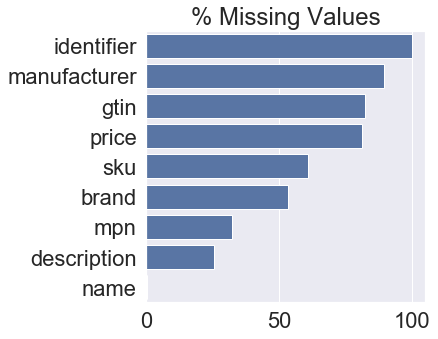

In [24]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=2)

sns.barplot(x=null_percentages.values, 
            y=null_percentages.index, 
            color="b")\
            .set_title('% Missing Values')

Text(0.5,1,'Figure 3. Missing Value Correlation')

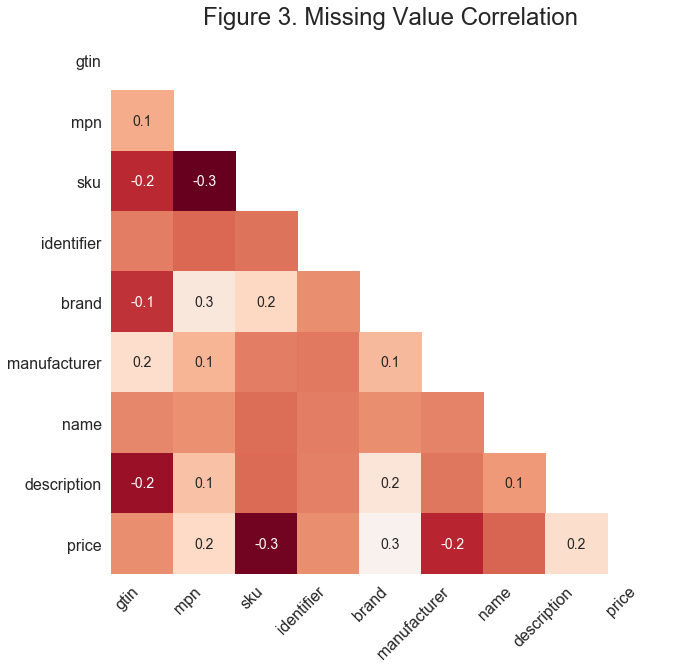

In [66]:
sns.set(font_scale=2)
msno.heatmap(train_test_offer_features_only, figsize=(10, 10)).set_title("Figure 3. Missing Value Correlation")



### Text Lengths



In [26]:
# count words
medium_long_features = train_test_normalized_features[MEDIUM_LONG_TEXT_FEATURES]
word_counts_df = medium_long_features.apply(count_words, axis=1)

[None]

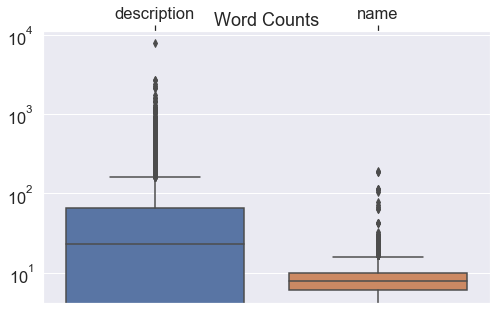

In [27]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.5)

ax = sns.boxplot(data = word_counts_df)
ax.set_title('Word Counts')
ax.xaxis.tick_top()
ax.set(yscale='log')

In [55]:
# count chararters for short-text features
short_text_features = train_test_normalized_features[SHORT_TEXT_FEATURES]
char_counts_df = short_text_features.apply(lambda s: s.str.len(), axis=1)

[None]

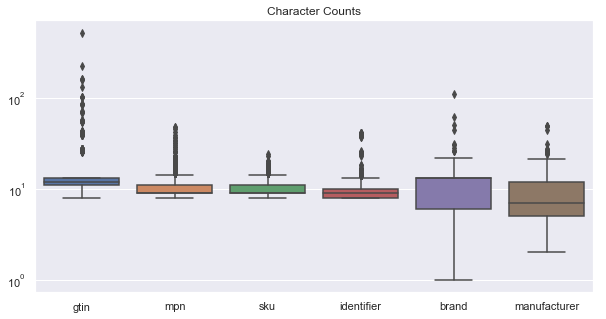

In [50]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1)

ax = sns.boxplot(data = char_counts_df)
ax.set_title('Character Counts')
ax.set(yscale='log')

### Top Values by Attribute

In [30]:
top_values =\
    train_test_normalized_features[['brand', 'manufacturer']]\
        .melt()\
        .dropna().groupby(['variable', 'value'])['value'].agg('count')\
        .to_frame()\
        .rename(index=str, columns={'value': 'value_counts'})\
        .reset_index()\
        .groupby(['variable'])\
        .apply(lambda x: x.nlargest(10, 'value_counts'))\
        .reset_index(drop=True)

top_values['value'] = top_values.value.str.slice(stop=25)

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


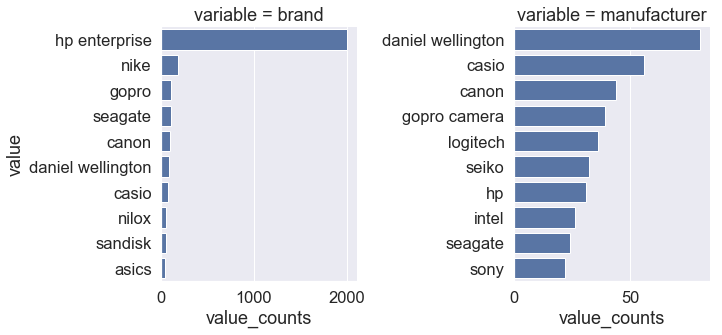

In [31]:
g = sns.FacetGrid(top_values, col="variable", col_wrap=5, sharey=False, sharex=False)
g.fig.set_figwidth(25)
g.fig.set_figheight(5)

g.map(sns.barplot, 'value_counts', 'value')

### Unique Value Counts

In [32]:
unique_values = train_test_normalized_features[ALL_FEATURES].apply(pd.Series.nunique, axis=0).sort_values(ascending=False)

Text(0.5,1,'Unique Values')

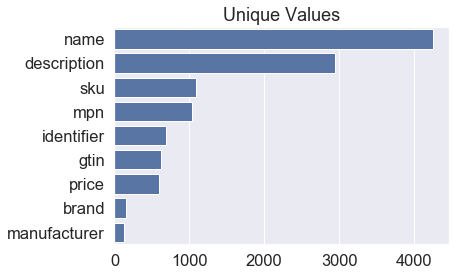

In [33]:
sns.barplot(x = unique_values, y=unique_values.index, 
            color="b")\
            .set_title('Unique Values')

### Training & Testing Data Characteristics

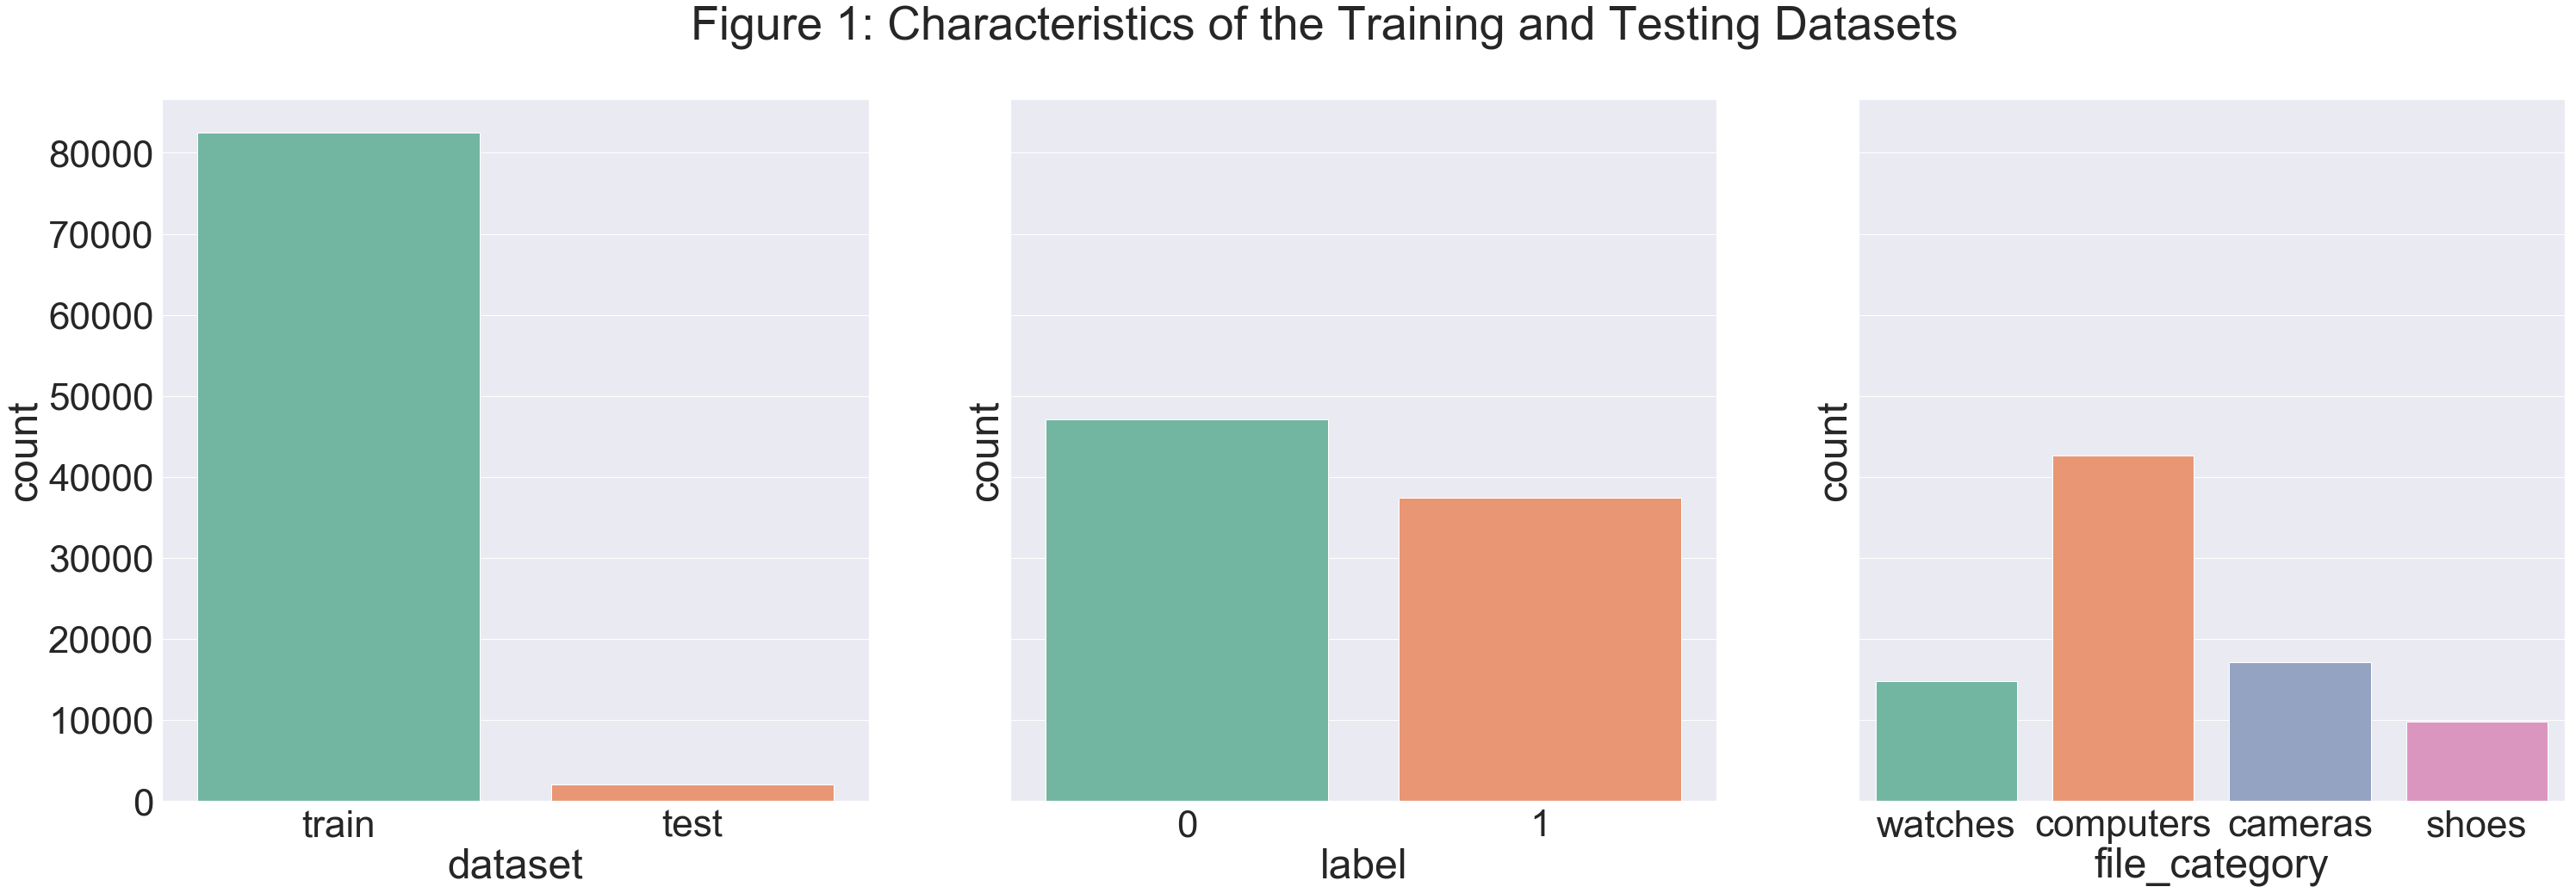

In [73]:
test_train_characteristics = train_test_feature_pairs[['label', 'dataset', 'file_category']]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(50, 15), sharey=True) 

sns.set(font_scale=2)
plt.rcParams.update({'font.size': 45})
st = fig.suptitle("Figure 1: Characteristics of the Training and Testing Datasets")

sns.countplot(x='dataset', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[0])

# mosaic plot: https://www.statsmodels.org/dev/generated/statsmodels.graphics.mosaicplot.mosaic.html
sns.countplot(x='label', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[1])

sns.countplot(x='file_category', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[2])

### Testing Data Characteristics


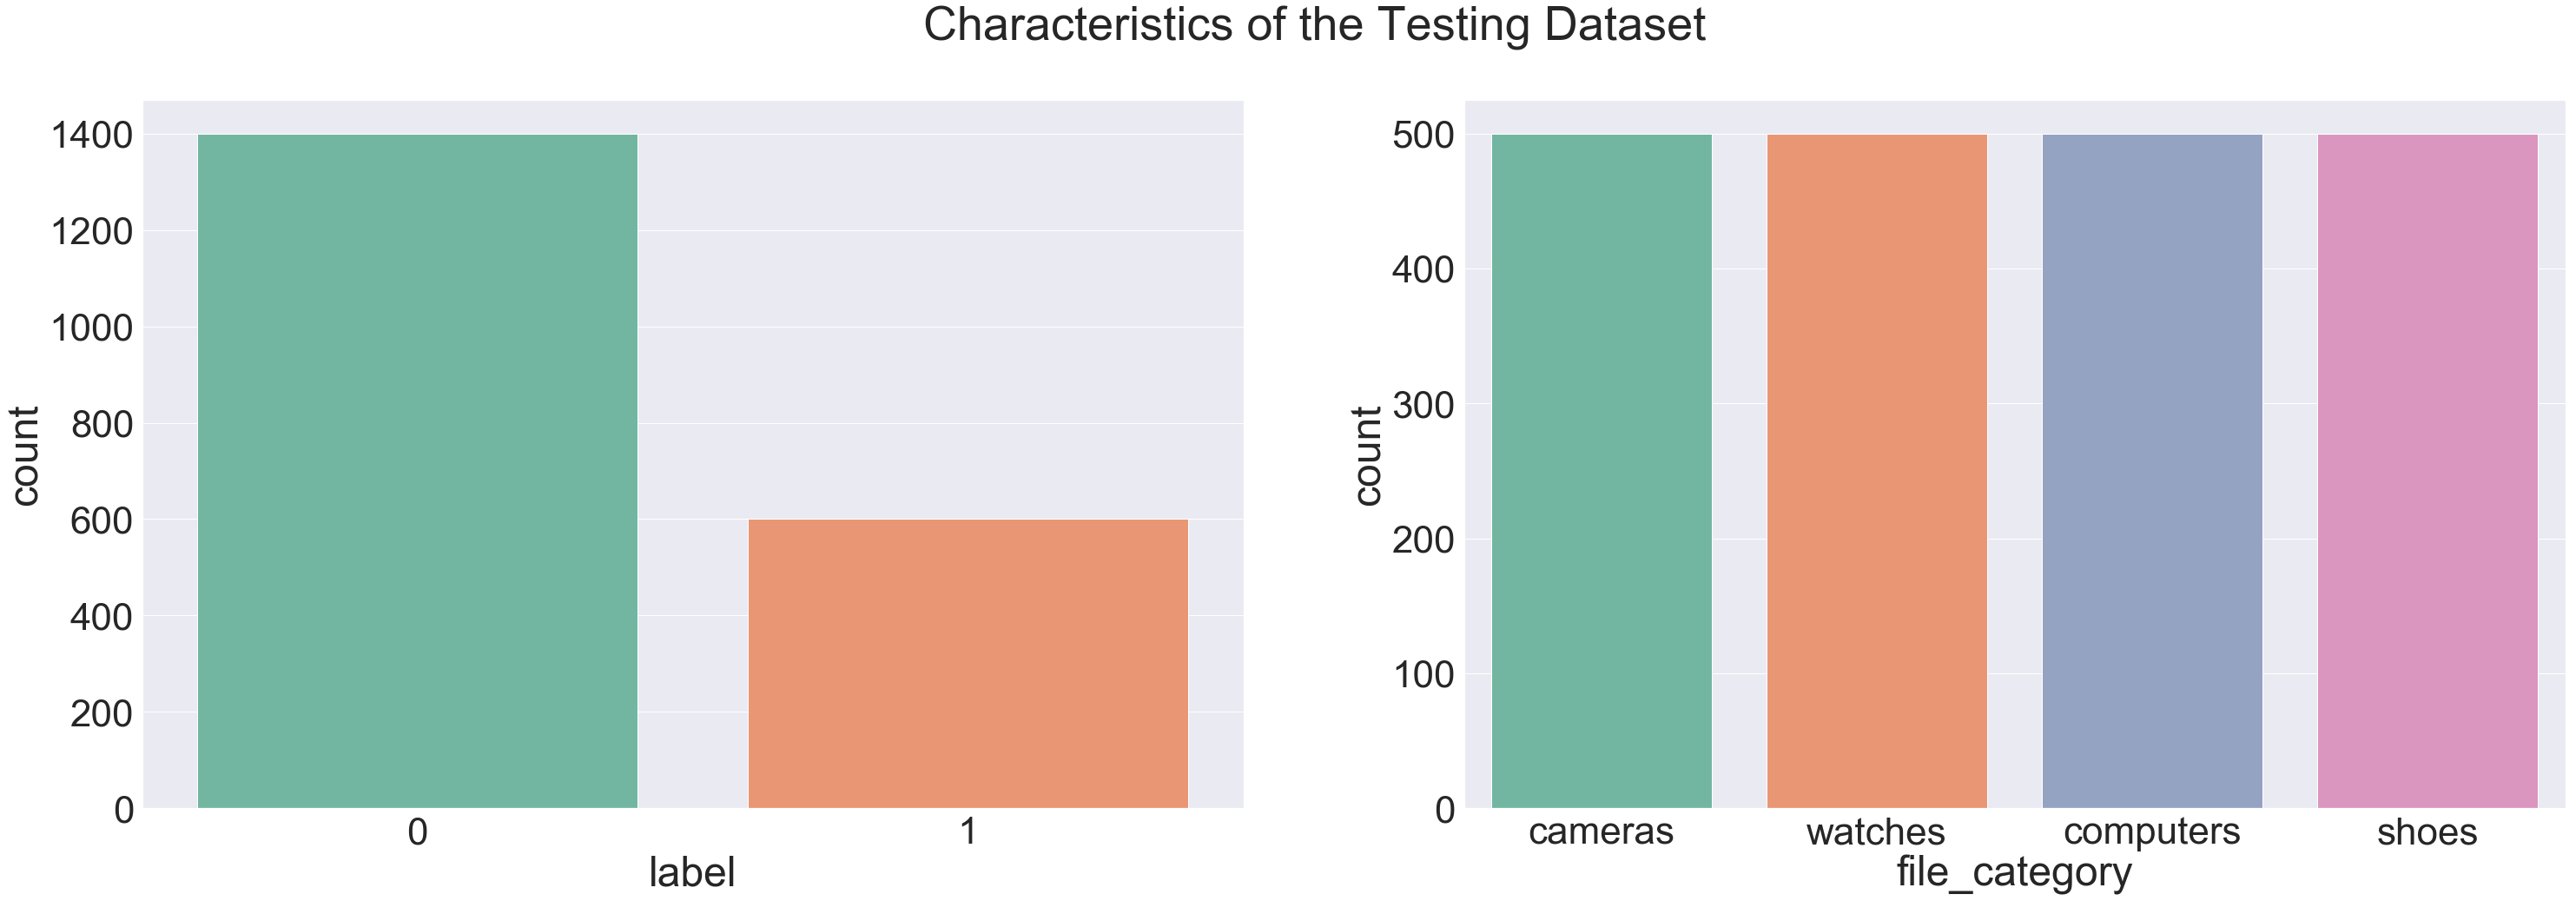

In [35]:
test_characteristics = test_train_characteristics[test_train_characteristics.dataset == 'test']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15)) #

sns.set(font_scale=4)
plt.rcParams.update({'font.size': 45})
st = fig.suptitle("Characteristics of the Testing Dataset")

sns.countplot(x='label', data=test_characteristics, palette=sns.color_palette("Set2"), ax=axes[0])

sns.countplot(x='file_category', data=test_characteristics, palette=sns.color_palette("Set2"), ax=axes[1])

### Feature Sets

1. Attribute Comparison Features: Measured the similarity between each offer pair's attribute values

    a. Levenshtein distance
    
    b. Bag-of-words & cosine similarity
    


2. Single Document Features
    
    a. Concatenated all features into a single string
    
    b. Encoded the attributes using TF-IDF bag-of-words
    
    c. Reduced the dimensionality using truncated SVD
    
    d. Absolute difference between the vectors



### Feature Analysis

Text(0.5,1,'Variable Coefficients')

<Figure size 576x1440 with 0 Axes>

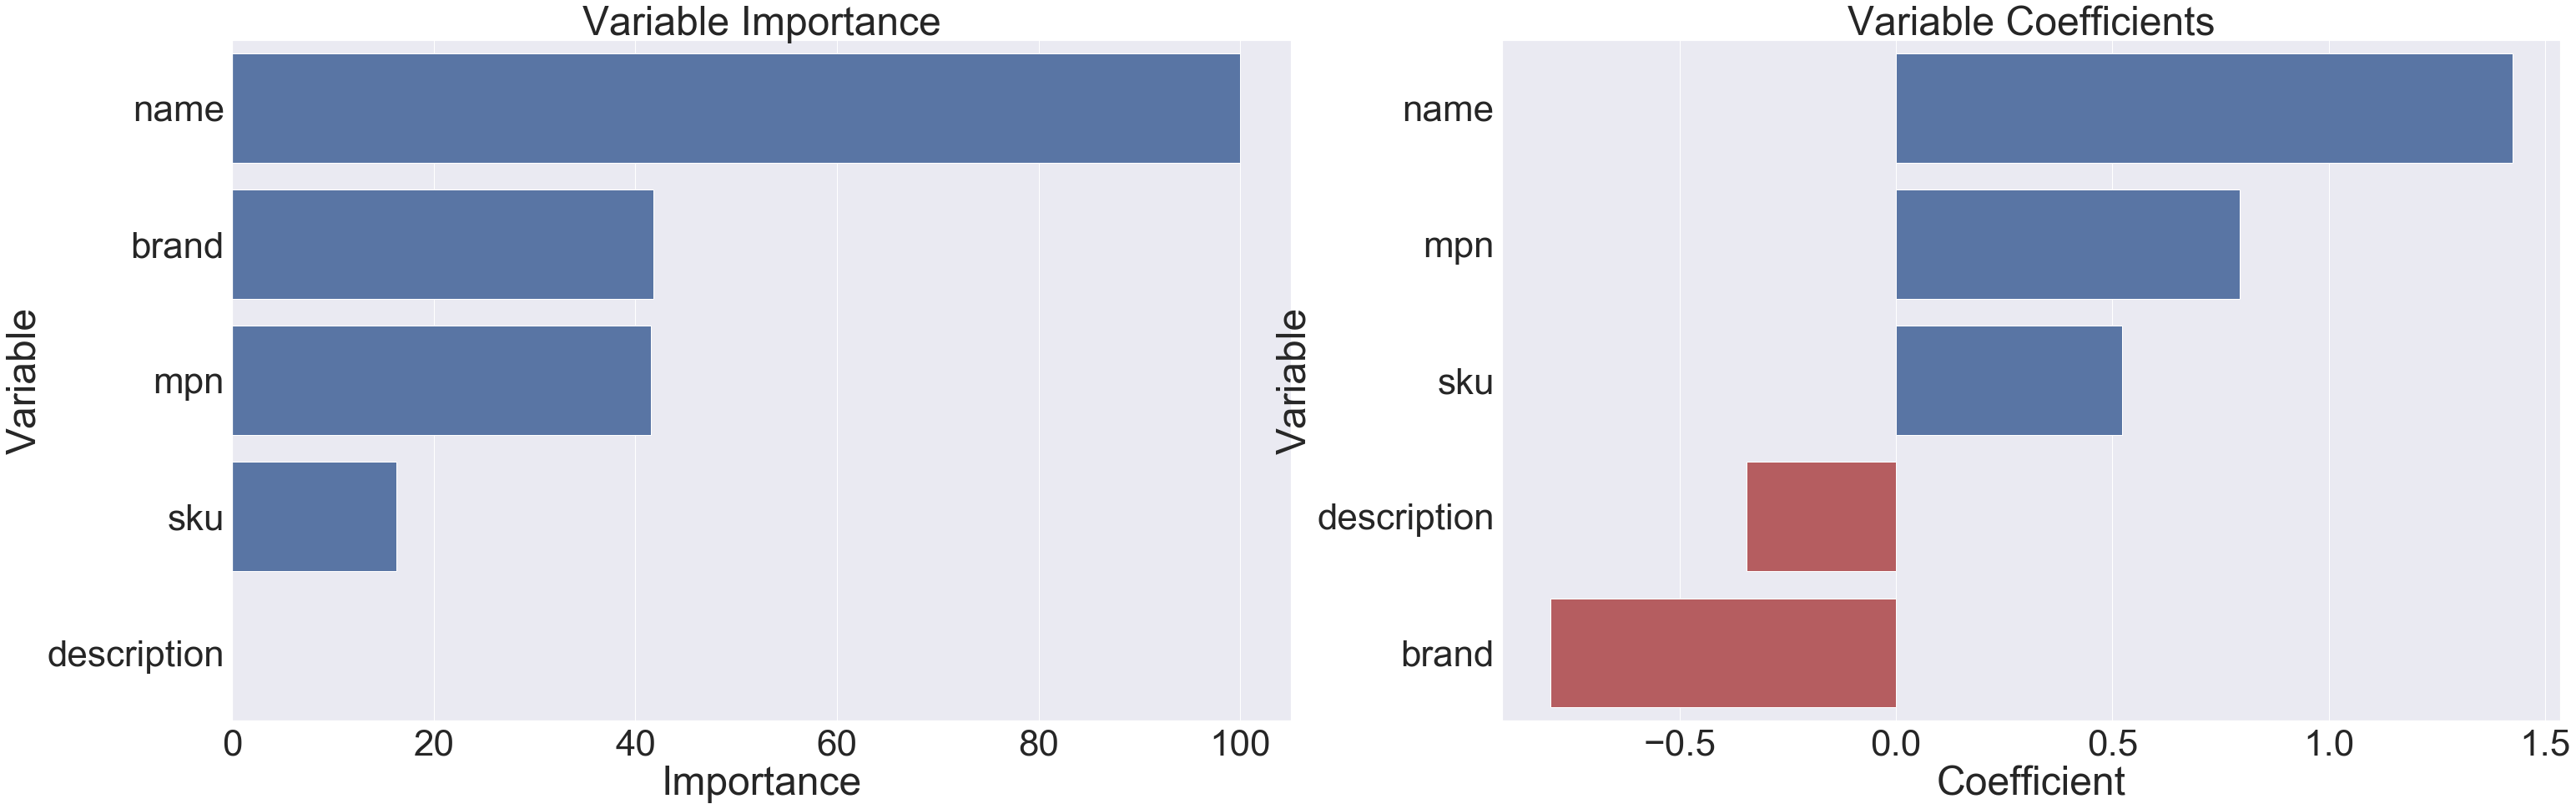

In [36]:
plt.figure(figsize=(8, 20))
sns.set(font_scale=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15))
sns.barplot(x=var_importance.Importance, 
            y=var_importance.index, 
            color="b", 
            ax=axes[0])\
            .set_title('Variable Importance')



sns.barplot(x=var_coefficients.Coefficient, 
            y=var_coefficients.index, 
            palette=var_coefficients.Coefficient.apply(lambda x: 'b' if x > 0 else 'r'),
            ax=axes[1])\
            .set_title('Variable Coefficients')

### Models

## Results